In [1]:
import scanpy as sc
import bbknn  # pip install bbknn
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp

# 1. Read both datasets --------------------------------------
adata= sc.read_h5ad("/Users/apple/Desktop/KB/data/Cell_tag-Cell_tag_multi_integrated/Seurat_method/cell_tag_multi_integrated_seurat.h5ad") 

In [2]:
adata

AnnData object with n_obs × n_vars = 28772 × 1960
    obs: 'nCount_RNA', 'nFeature_RNA', 'X', 'orig.ident', 'nCount_RNA.1', 'nFeature_RNA.1', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'RNA_snn_res.0.8', 'seurat_clusters', 'sample', 'replicate', 'predicted.id_cca_co', 'prediction.score.Fib_1_cca_co', 'prediction.score.Fib_0_cca_co', 'prediction.score.Fib_2_cca_co', 'prediction.score.Early_0_cca_co', 'prediction.score.Tran_0_cca_co', 'prediction.score.Tran_1_cca_co', 'prediction.score.Early_1_cca_co', 'prediction.score.Early_2_cca_co', 'prediction.score.iEP_1_cca_co', 'prediction.score.Tran_2_cca_co', 'prediction.score.iEP_2_cca_co', 'prediction.score.Dead.end_1_cca_co', 'prediction.score.Dead.end_0_cca_co', 'prediction.score.iEP_0_cca_co', 'prediction.score.Dead.end_2_cca_co', 'prediction.score.max_cca_co', 'RNA_snn_res.0.2', 'cellranger_ident', 'md_fate_rev1', 'md_fate_coarse_rev1', 'cell_name', 'assigned_lineage', 'has_lineage', 'n_genes_by_counts', 

In [3]:
adata.obsm = {}
adata.obsp = {}
print("Cleared obsm and obsp. Ready for new UMAP computation.")

Cleared obsm and obsp. Ready for new UMAP computation.


In [4]:
# Compute PCA (we'll do e.g. up to 30 PCs and then use the first 30 for neighbors)
adata.obsm["X_pca"] = sc.tl.pca(adata.X, n_comps=30)

# Build neighborhood graph using top 30 PCs
sc.pp.neighbors(adata, use_rep="X_pca", n_pcs=30)

# Compute UMAP
sc.tl.umap(adata)

/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


### check the integration

/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


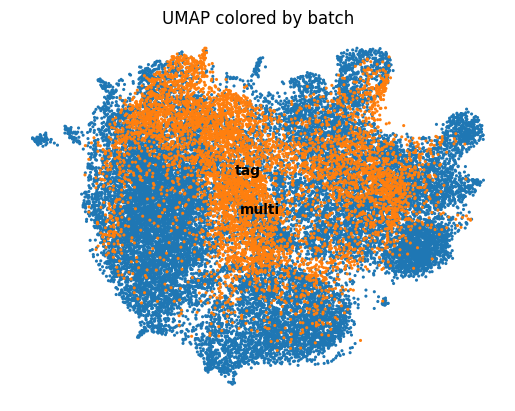

In [5]:
sc.pl.umap(
    adata,
    color="batch",
    legend_loc="on data",     # or "right margin"
    title="UMAP colored by batch",
    size=20,                  # point size
    frameon=False            # removes box around legend
)

plt.show()

### check the count normalization

In [7]:
adata.X[0:10,0:10]

array([[-2.25020893e-01, -2.37295345e-01,  1.17509440e+00,
        -4.74205286e-01, -1.35450317e-01, -7.08030800e-01,
         3.31327227e+00, -1.13271883e-01, -3.27523398e-01,
        -1.26774598e-01],
       [-2.25020893e-01, -2.37295345e-01, -5.26258275e-01,
        -4.74205286e-01, -1.35450317e-01, -7.08030800e-01,
        -3.99281755e-01, -1.13271883e-01, -3.27523398e-01,
        -1.26774598e-01],
       [-2.25020893e-01, -2.37295345e-01,  1.85849418e+00,
         2.42535445e+00, -1.35450317e-01, -7.08030800e-01,
        -3.99281755e-01, -1.13271883e-01, -3.27523398e-01,
        -1.26774598e-01],
       [-2.25020893e-01, -2.37295345e-01, -5.26258275e-01,
        -4.74205286e-01, -1.35450317e-01,  8.61317436e-02,
         1.57696511e+00, -1.13271883e-01, -3.27523398e-01,
        -1.26774598e-01],
       [-2.25020893e-01, -2.37295345e-01, -5.26258275e-01,
        -4.74205286e-01, -1.35450317e-01, -7.08030800e-01,
        -3.99281755e-01, -1.13271883e-01, -3.27523398e-01,
         9.

In [7]:
# grab the data array
X = adata.X
if sp.issparse(X):
    vals = X.data
else:
    vals = X.ravel()

# 1) type & integer‐ness
print("dtype:", vals.dtype)
print("all integers? ", np.allclose(vals, np.round(vals)))

# 2) basic range
print("min:", vals.min(), " max:", vals.max(), 
      " mean:", np.mean(vals), " median:", np.median(vals))

# 3) per‐cell sums (if you did normalize_total, these will be constant)
if sp.issparse(X):
    cell_sums = np.array(X.sum(axis=1)).ravel()
else:
    cell_sums = X.sum(axis=1)
print("cell sum  stats → min:", cell_sums.min(), 
      " max:", cell_sums.max(), 
      " mean:", cell_sums.mean())

# 4) check for raw layer
if adata.raw is not None:
    print("\nadata.raw found.  raw X stats:",
          " min:", adata.raw.X.min(),
          " max:", adata.raw.X.max())
else:
    print("\nNo adata.raw layer present.")

dtype: float64
all integers?  False
min: -17.434771831903674  max: 10.0  mean: -0.005227112280344067  median: -0.12192735514188247
cell sum  stats → min: -699.1396145277034  max: 1149.5615608126081  mean: -10.245140069474392

adata.raw found.  raw X stats:  min: -4.688288666767084  max: 8.791973727392765


In [8]:
adata.raw

### split the train/test dataset

In [10]:
# 1) split by batch
is_test    = adata.obs["batch"] == "multi"
adata_test = adata[is_test].copy()
adata_train= adata[~is_test].copy()

print(f"train cells: {adata_train.n_obs}; test cells: {adata_test.n_obs}")

print("test cells: ",  adata_test.X.shape)
print("train cells:",   adata_train.X.shape)

train cells: 6534; test cells: 22238
test cells:  (22238, 1960)
train cells: (6534, 1960)


In [12]:
adata_test.raw  = None
adata_train.raw = None

adata_test.write_h5ad("cellTag_test_multi_Seurat.h5ad")
adata_train.write_h5ad("cellTag_train_tag_Seurat.h5ad")